The purpose of this notebook is to create example json files (similar to however a backend API would be serving data) for the time matrix to be in the next version of the IMPACTS dashboard.

In [2]:
import pathlib
import glob
import os

import argparse
import geojson
import pandas as pd
import json
import random

from datetime import datetime, timedelta

In [3]:
# Helper array for day indexing
aggregateMonths = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
nsims = 10000

In [4]:
jsonResponse = []

In [5]:
# Read in example psv
file = '../data/output/examples/20210428124600.psv.gz'
df = pd.read_csv(file, sep="|")

<AxesSubplot:>

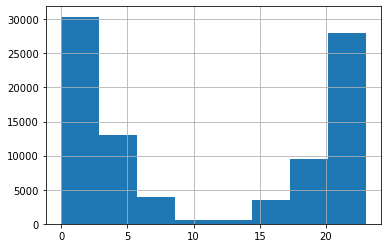

In [6]:
df['time'].hist(bins=8)

### Binning

In [16]:
bin_labels = ['00-03','03-06','06-09','09-12','12-15','15-18','18-21','21-00']
# lower bound is not inclusive, so we shift the thresholds one to the left
cut_bins = [-1,2,5,8,11,14,17,20,23]

# Add the hour bins to the original dataframe
df['hourBins'] = pd.cut(df['time'], bins=cut_bins, labels=bin_labels)

In [51]:
# Group by simulation and hour bin and sum our population in each group
grouped = df.groupby(['sim','hourBins']).agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})

# Move the indices to columns and pivot the sim column back to the index, then ensure we have 10000 sims in the df by reindexing
formatted = grouped.reset_index().pivot(index='sim',columns='hourBins').reindex(list(range(1,10001)),fill_value=0)

# Get the stats
hourBinStats_All = formatted.describe(percentiles=[0.1,0.5,0.9]).loc[['10%','50%','90%']]
hourBinStats_All.rename(index={'10%':'0.1','50%':'0.5','90%':'0.9'},inplace=True)


In [52]:
hourBinStats_All

population                                                     \
                sum                                                      
hourBins      00-03   03-06  06-09 09-12 12-15  15-18   18-21    21-00   
0.1             0.0     0.0    0.0   0.0   0.0    0.0     0.0      0.0   
0.5           608.0    16.0    0.0   0.0   0.0    0.0     0.0    608.0   
0.9         13958.4  3284.8  433.6   0.0   0.0  320.0  2977.6  10720.0   

         hospitals        ... psubstations       mobilehomes              \
               sum        ...          sum               sum               
hourBins     00-03 03-06  ...        18-21 21-00       00-03 03-06 06-09   
0.1            0.0   0.0  ...          0.0   0.0         0.0   0.0   0.0   
0.5            0.0   0.0  ...          0.0   0.0         0.0   0.0   0.0   
0.9            0.0   0.0  ...          1.0   3.0       100.0   0.0   0.0   

                                        
                                        
hourBins 09-12 12-15 15-18 18-21 21-00  
0.1        0.0   0.0   0.0   0.0   0.0  
0.5        0.0   0.0   0.0   0.0   0.0  
0.9        0.0   0.0   0.0   0.0  75.0  

[3 rows x 32 columns]

In [42]:
nationalResponse = {
    'Location': 'National',
    'Type': 'National',
    'Timing': {}
}

In [43]:
impacts = ['population','hospitals','mobilehomes','psubstations']

Using the regular binned percentiles

In [44]:
for name in impacts:
    nationalResponse['Timing'][name] = {}
    
    for hourBin in hourBinStats_All[name]['sum'].columns:
        
        nationalResponse['Timing'][name][hourBin] = {}
        
        for quant in hourBinStats_All[name]['sum'].index:
            
            nationalResponse['Timing'][name][hourBin][quant] = \
                int(hourBinStats_All[name]['sum'].loc[quant,hourBin])

In [ ]:
for name in impacts:
    nationalResponse['Timing'][name] = {}

In [46]:
jsonResponse.append(nationalResponse)

In [48]:
with open ('../data/output/examples/jsonResponse_time.json','w') as fp:
    json.dump(jsonResponse, fp)

### No Binning

In [53]:
grouped_nb = df.groupby(['sim','time']).agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})

In [54]:
# Move the indices to columns and pivot the sim column back to the index, then ensure we have 10000 sims in the df by reindexing
formatted_nb = grouped_nb.reset_index().pivot(index='sim',columns='time').reindex(list(range(1,10001)),fill_value=0)

In [57]:
formatted_nb.fillna(0,inplace=True)

# Get the stats
hourBinStats_nb = formatted_nb.describe(percentiles=[0.1,0.5,0.9]).loc[['10%','50%','90%']]
hourBinStats_nb.rename(index={'10%':'0.1','50%':'0.5','90%':'0.9'},inplace=True)

### Sum by Time

In [87]:
grouped_time = df.groupby(['time']).agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})
formatted_time = grouped_time.reindex(list(range(0,24)),fill_value=0)
formatted_time.head()

,population,hospitals,psubstations,mobilehomes
,sum,sum,sum,sum
time,,,,
0,20874736,690,4182,105625
1,21994528,647,3945,109825
2,13447552,379,2221,64025
3,10985488,357,1704,51000
4,9717216,387,1251,40875


Using the summed individual hours

In [88]:
jsonResponse = []

In [79]:
nationalResponse = {
    'Location': 'National',
    'Type': 'National',
    'Timing': {}
}

In [80]:
impacts = ['population','hospitals','mobilehomes','psubstations']

In [84]:
for name in impacts:
    nationalResponse['Timing'][name] = {}
    
    for hour in formatted_time[name]['sum'].index:
        
        nationalResponse['Timing'][name][hour] = \
            int(formatted_time[name].loc[hour,'sum'])

In [90]:
jsonResponse.append(nationalResponse)

In [92]:
jsonResponse

[{'Location': 'National',
  'Type': 'National',
  'Timing': {'population': {0: 20874736,
    1: 21994528,
    2: 13447552,
    3: 10985488,
    4: 9717216,
    5: 5441824,
    6: 3086496,
    7: 2006352,
    8: 1528944,
    9: 1057904,
    10: 200928,
    11: 79728,
    12: 15296,
    13: 76096,
    14: 647120,
    15: 777984,
    16: 2391936,
    17: 4363920,
    18: 5168128,
    19: 5541200,
    20: 8013168,
    21: 9689456,
    22: 15826880,
    23: 17648336},
   'hospitals': {0: 690,
    1: 647,
    2: 379,
    3: 357,
    4: 387,
    5: 184,
    6: 103,
    7: 68,
    8: 29,
    9: 22,
    10: 4,
    11: 2,
    12: 0,
    13: 2,
    14: 33,
    15: 33,
    16: 70,
    17: 102,
    18: 126,
    19: 173,
    20: 225,
    21: 307,
    22: 456,
    23: 543},
   'mobilehomes': {0: 105625,
    1: 109825,
    2: 64025,
    3: 51000,
    4: 40875,
    5: 25725,
    6: 17775,
    7: 9625,
    8: 9950,
    9: 5525,
    10: 3400,
    11: 425,
    12: 100,
    13: 1200,
    14: 2200,
    15: 

### States

In [93]:
stBrokenOut = df.assign(category=df['states'].str.split(',')).explode('category').reset_index(drop=True)

# Remove row if state is NaN
stBrokenOut = stBrokenOut[stBrokenOut['category'].notna()]

# Grab a list of the unique states in the simulation
statesImpacted = stBrokenOut['category'].unique().tolist()

In [94]:
impacts = ['population','hospitals','mobilehomes','psubstations']

for state in statesImpacted:
    
    stateResponse = {
        'Location': state,
        'Type': 'State',
        'Timing': {}
    }
    
    ind_state = stBrokenOut[stBrokenOut['category'] == state]

    ind_state_group = ind_state.groupby("time").agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})
    
    ind_state_tot = ind_state_group.reindex(list(range(0,24)),fill_value=0)
    
    for name in impacts:
        stateResponse['Timing'][name] = {}

        for hour in ind_state_tot[name]['sum'].index:

            stateResponse['Timing'][name][hour] = \
                int(ind_state_tot[name].loc[hour,'sum'])
    
    jsonResponse.append(stateResponse)

### CWAs

In [96]:
cwaBrokenOut = df.assign(category=df['wfos'].str.split(',')).explode('category').reset_index(drop=True)

# Remove row if state is NaN
cwaBrokenOut = cwaBrokenOut[cwaBrokenOut['category'].notna()]

# Grab a list of the unique states in the simulation
cwasImpacted = cwaBrokenOut['category'].unique().tolist()

In [98]:
impacts = ['population','hospitals','mobilehomes','psubstations']

for cwa in cwasImpacted:
    
    cwaResponse = {
        'Location': cwa,
        'Type': 'CWA',
        'Timing': {}
    }
    
    ind_cwa = cwaBrokenOut[cwaBrokenOut['category'] == cwa]

    ind_cwa_group = ind_cwa.groupby("time").agg({'population': ['sum'], 'hospitals': ['sum'],
                                             'psubstations': ['sum'], 'mobilehomes': ['sum']})
    
    ind_cwa_tot = ind_cwa_group.reindex(list(range(0,24)),fill_value=0)
    
    for name in impacts:
        cwaResponse['Timing'][name] = {}

        for hour in ind_cwa_tot[name]['sum'].index:

            cwaResponse['Timing'][name][hour] = \
                int(ind_cwa_tot[name].loc[hour,'sum'])
    
    jsonResponse.append(cwaResponse)

In [100]:
with open ('../data/output/examples/jsonResponse_time_sum.json','w') as fp:
    json.dump(jsonResponse, fp)

In [99]:
jsonResponse

[{'Location': 'National',
  'Type': 'National',
  'Timing': {'population': {0: 20874736,
    1: 21994528,
    2: 13447552,
    3: 10985488,
    4: 9717216,
    5: 5441824,
    6: 3086496,
    7: 2006352,
    8: 1528944,
    9: 1057904,
    10: 200928,
    11: 79728,
    12: 15296,
    13: 76096,
    14: 647120,
    15: 777984,
    16: 2391936,
    17: 4363920,
    18: 5168128,
    19: 5541200,
    20: 8013168,
    21: 9689456,
    22: 15826880,
    23: 17648336},
   'hospitals': {0: 690,
    1: 647,
    2: 379,
    3: 357,
    4: 387,
    5: 184,
    6: 103,
    7: 68,
    8: 29,
    9: 22,
    10: 4,
    11: 2,
    12: 0,
    13: 2,
    14: 33,
    15: 33,
    16: 70,
    17: 102,
    18: 126,
    19: 173,
    20: 225,
    21: 307,
    22: 456,
    23: 543},
   'mobilehomes': {0: 105625,
    1: 109825,
    2: 64025,
    3: 51000,
    4: 40875,
    5: 25725,
    6: 17775,
    7: 9625,
    8: 9950,
    9: 5525,
    10: 3400,
    11: 425,
    12: 100,
    13: 1200,
    14: 2200,
    15: 